In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
df = pd.read_csv("AMZN.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6516.000000,6516.000000,6516.000000,6516.000000,6516.000000,6.516000e+03
mean,31.611626,31.991995,31.193432,31.599740,31.599740,1.425338e+08
std,48.095343,48.659651,47.464476,48.060258,48.060258,1.401619e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,1.998875,2.028500,1.964750,2.001250,2.001250,6.888182e+07
50%,6.456750,6.535500,6.353250,6.444250,6.444250,1.059050e+08
75%,38.451375,38.688000,38.203001,38.464625,38.464625,1.607700e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [6]:
df_trim = df[["Date", "Open", "High", "Low", "Volume", "Close"]]

In [7]:
df_trim["Date"] = pd.to_datetime(df_trim["Date"])

/var/folders/86/2cfgk86s0b5ck9yg4rt2y2f40000gn/T/ipykernel_17138/373635155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim["Date"] = pd.to_datetime(df_trim["Date"])


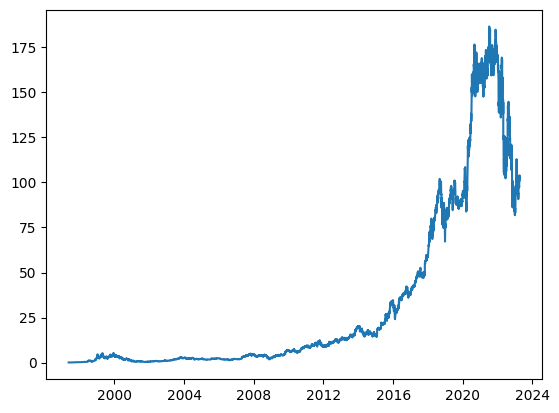

In [8]:
plt.plot(df_trim["Date"], df_trim["Close"])

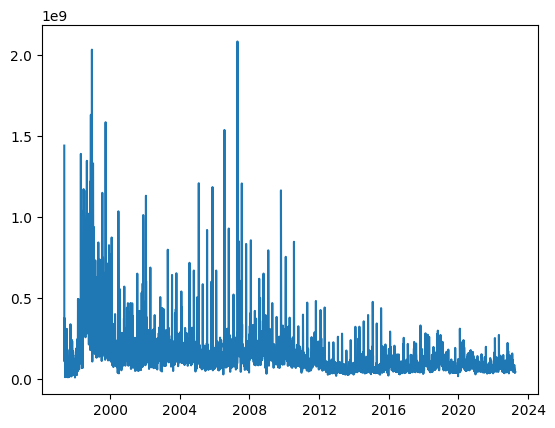

In [9]:
plt.plot(df_trim["Date"], df_trim["Volume"])

In [10]:
# Scale columns between -1 and 1
def scale_columns(df, columns):
    scaled_data = scaler.fit_transform(df[columns])
    print(scaled_data.shape)
    df[columns] = scaled_data
    return df
df_trim_scaled = scale_columns(df_trim, ["Open", "Close", "High", "Low", "Volume"])

(6516, 5)


/var/folders/86/2cfgk86s0b5ck9yg4rt2y2f40000gn/T/ipykernel_17138/2810624330.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = scaled_data


In [11]:
def create_history_columns(df, pred_col, feature_cols, n_steps):
    df_shifted = df.copy()
    for i in range(n_steps, 0, -1):
        df_shifted[f"Sequence(t-{i})"] = [None] * len(df_shifted)     
    
    for row in df_shifted.itertuples():
        if row[0] < n_steps:
            continue
            
        for i in range(n_steps, 0, -1): 
            df_shifted.at[row[0], f"Sequence(t-{i})"] = [df_shifted.at[row[0]-i, col] for col in feature_cols]
    return df_shifted

sequence = 10
p_col = "Close"
f_cols = ["Open", "Close", "High", "Low", "Volume"]
df_shifted = create_history_columns(df_trim_scaled, p_col, f_cols, sequence)
df_shifted.set_index('Date', inplace=True)
df_shifted.dropna(how='any', inplace=True)
data_np = df_shifted.to_numpy()
df_shifted

,Open,High,Low,Volume,Close,Sequence(t-10),Sequence(t-9),Sequence(t-8),Sequence(t-7),Sequence(t-6),Sequence(t-5),Sequence(t-4),Sequence(t-3),Sequence(t-2),Sequence(t-1)
Date,,,,,,,,,,,,,,,
1997-05-30,0.000025,0.000017,0.000045,0.020292,0.000028,"[0.0002755415330044591, 0.00015080372029051433...","[0.00015029683906268978, 8.93615929728608e-05,...","[9.462956181767506e-05, 8.377984460584129e-05,...","[8.627706548149783e-05, 6.423032054613583e-05,...","[6.123026424818844e-05, 8.375303505556706e-06,...","[8.347152448566052e-06, 0.0, 0.0, 0.0, 0.10871...","[0.0, 2.7924827565262167e-05, 1.93338045033457...","[2.783096667870183e-05, 5.0267906763504775e-05...","[5.844609880279605e-05, 3.630549298087372e-05,...","[3.617811912726788e-05, 2.9318924179503345e-05..."
1997-06-02,0.000028,0.000022,0.000051,0.001005,0.000031,"[0.00015029683906268978, 8.93615929728608e-05,...","[9.462956181767506e-05, 8.377984460584129e-05,...","[8.627706548149783e-05, 6.423032054613583e-05,...","[6.123026424818844e-05, 8.375303505556706e-06,...","[8.347152448566052e-06, 0.0, 0.0, 0.0, 0.10871...","[0.0, 2.7924827565262167e-05, 1.93338045033457...","[2.783096667870183e-05, 5.0267906763504775e-05...","[5.844609880279605e-05, 3.630549298087372e-05,...","[3.617811912726788e-05, 2.9318924179503345e-05...","[2.5046801233309386e-05, 2.7924827565262167e-0..."
1997-06-03,0.000033,0.000022,0.000045,0.006702,0.000022,"[9.462956181767506e-05, 8.377984460584129e-05,...","[8.627706548149783e-05, 6.423032054613583e-05,...","[6.123026424818844e-05, 8.375303505556706e-06,...","[8.347152448566052e-06, 0.0, 0.0, 0.0, 0.10871...","[0.0, 2.7924827565262167e-05, 1.93338045033457...","[2.783096667870183e-05, 5.0267906763504775e-05...","[5.844609880279605e-05, 3.630549298087372e-05,...","[3.617811912726788e-05, 2.9318924179503345e-05...","[2.5046801233309386e-05, 2.7924827565262167e-0...","[2.783096667870183e-05, 3.071838270379937e-05,..."
1997-06-04,0.000019,0.000011,0.000023,0.024973,0.000006,"[8.627706548149783e-05, 6.423032054613583e-05,...","[6.123026424818844e-05, 8.375303505556706e-06,...","[8.347152448566052e-06, 0.0, 0.0, 0.0, 0.10871...","[0.0, 2.7924827565262167e-05, 1.93338045033457...","[2.783096667870183e-05, 5.0267906763504775e-05...","[5.844609880279605e-05, 3.630549298087372e-05,...","[3.617811912726788e-05, 2.9318924179503345e-05...","[2.5046801233309386e-05, 2.7924827565262167e-0...","[2.783096667870183e-05, 3.071838270379937e-05,...","[3.339929756948667e-05, 2.2337717288187816e-05..."
1997-06-05,0.000003,0.000025,0.000017,0.049934,0.000039,"[6.123026424818844e-05, 8.375303505556706e-06,...","[8.347152448566052e-06, 0.0, 0.0, 0.0, 0.10871...","[0.0, 2.7924827565262167e-05, 1.93338045033457...","[2.783096667870183e-05, 5.0267906763504775e-05...","[5.844609880279605e-05, 3.630549298087372e-05,...","[3.617811912726788e-05, 2.9318924179503345e-05...","[2.5046801233309386e-05, 2.7924827565262167e-0...","[2.783096667870183e-05, 3.071838270379937e-05,...","[3.339929756948667e-05, 2.2337717288187816e-05...","[1.947847034252455e-05, 5.581748367019504e-06,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30,0.542296,0.546011,0.546313,0.021133,0.546541,"[0.5113014939949345, 0.5360312688149425, 0.535...","[0.5328908052877382, 0.5301867654075987, 0.533...","[0.5255162564160585, 0.5235380076634992, 0.521...","[0.5240733800416186, 0.5390875575461636, 0.534...","[0.5364177497355256, 0.5288462878939053, 0.541...","[0.5363108880149662, 0.5288999177182732, 0.535...","[0.5236993132527279, 0.5257899991626842, 0.520...","[0.5290432008638458, 0.5253074487053948, 0.526...","[0.5239130741010602, 0.5210179045758455, 0.521...","[0.5270125342593963, 0.5371572645645349, 0.532..."
2023-03-31,0.545556,0.548397,0.551400,0.022611,0.553457,"[0.5328908052877382, 0.5301867654075987, 0.533...","[0.5255162564160585, 0.5235380076634992, 0.521...","[0.5240733800416186, 0.5390875575461636, 0.534...","[0.5364177497355256, 0.5288462878939053, 0.541...","[0.5363108880149662, 0.528

In [12]:
X = data_np[:, 5:].tolist()
y = data_np[:, 4].tolist()
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(dim=-1)
X.shape, y.shape

(torch.Size([6506, 10, 5]), torch.Size([6506, 1]))

In [13]:
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index: ]
y_train, y_test = y[:split_index], y[split_index: ]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5855, 10, 5]),
 torch.Size([651, 10, 5]),
 torch.Size([5855, 1]),
 torch.Size([651, 1]))

In [14]:
class StockPriceForecastDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
train_dataset = StockPriceForecastDataset(X_train, y_train)
test_dataset = StockPriceForecastDataset(X_test, y_test)

b_size = 24
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, stacked_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.stacked_layers = stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, stacked_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
    
    def forward(self, x):
        b_size = x.shape[0]
        hidden_state = torch.zeros([self.stacked_layers * 2, b_size, self.hidden_size]).to(device)
        cell_state = torch.zeros([self.stacked_layers * 2, b_size, self.hidden_size]).to(device)
        # out - Hidden state of each timestep: (b_size, timesteps, hidden_size)
        # _ : Hidden state of the LSTM. Its a tuple of N tensors, one for the hidden state of each layer.
        out, _ = self.lstm(x, (hidden_state, cell_state))
        out = self.fc(out[:, -1, :])
        return out 

In [16]:
model = LSTMModel(5, 4, 2)
model.to(device)

LSTMModel(
  (lstm): LSTM(5, 4, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
for index, batch in enumerate(train_loader):
    inp, gt = batch[0].to(device), batch[1].to(device)
    print(inp.shape)
    break

torch.Size([24, 10, 5])


In [39]:
# Training 
lr = 0.001
epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train(True)
for epoch in range(epochs):
    print(f"Running Epoch {epoch+1}")
    running_loss = 0. 
    for index, batch in enumerate(train_loader):
        inp, gt = batch[0].to(device), batch[1].to(device)
        pred = model(inp)
        loss = loss_function(pred, gt)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if index > 0 and index % 50 == 0:
            avg_batch_loss = running_loss / 50.
            print(f"Batch: {index}, Average Loss: {avg_batch_loss}")
            running_loss = 0.

Running Epoch 1
Batch: 50, Average Loss: 0.024532973766326904
Batch: 100, Average Loss: 0.013102131895720959
Batch: 150, Average Loss: 0.003331106621772051
Batch: 200, Average Loss: 0.0008238626760430634
Running Epoch 2
Batch: 50, Average Loss: 0.0007843002676963806
Batch: 100, Average Loss: 0.0005546336760744452
Batch: 150, Average Loss: 0.00029623546288348734
Batch: 200, Average Loss: 0.000260595086729154
Running Epoch 3
Batch: 50, Average Loss: 0.00020833751477766782
Batch: 100, Average Loss: 0.00016330282960552722
Batch: 150, Average Loss: 8.731114940019324e-05
Batch: 200, Average Loss: 6.638783816015348e-05
Running Epoch 4
Batch: 50, Average Loss: 5.6770943047013134e-05
Batch: 100, Average Loss: 5.1373743190197274e-05
Batch: 150, Average Loss: 4.485286626731977e-05
Batch: 200, Average Loss: 4.39562281826511e-05
Running Epoch 5
Batch: 50, Average Loss: 4.1052895539905876e-05
Batch: 100, Average Loss: 7.170579920057207e-05
Batch: 150, Average Loss: 5.062618583906442e-05
Batch: 200, 

In [40]:
# Validation 
model.train(False)
running_loss = 0.

for index, batch in enumerate(test_loader):
    inp, gt = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        pred = model(inp)
        loss = loss_function(pred, gt)
        running_loss += loss

avg_batch_loss = running_loss / len(test_loader)
print(f"Test Loss: {avg_batch_loss}")

Test Loss: 0.0011503177229315042


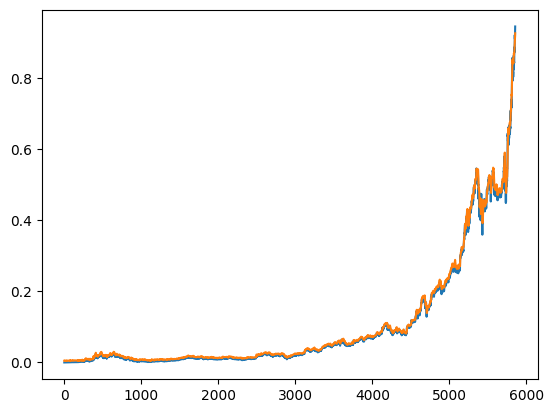

In [41]:
pred = model(X_train).detach().numpy()
plt.plot(y_train.numpy(), label="Actual_Close")
plt.plot(pred, label="Predicted_Close")
plt.show()

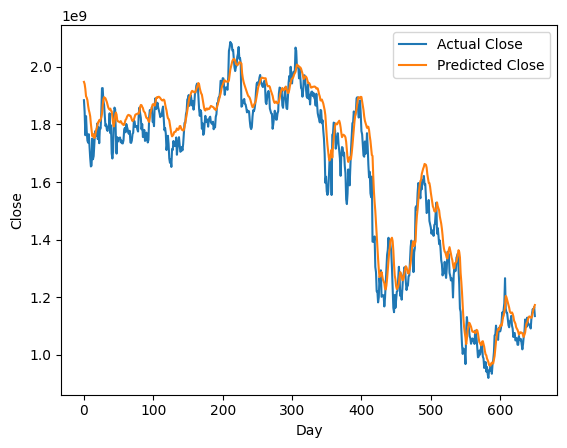

In [42]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Inverse Scale predictions
dummies = np.zeros((X_test.shape[0], len(f_cols)))
dummies[:, -1] = test_predictions # The last column corresponds to Close Column
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, -1])

# Inverse Scale actual values
dummies[:, -1] = y_test.numpy().flatten()
dummies = scaler.inverse_transform(dummies)
actual = dc(dummies[:, -1])

plt.plot(actual, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [20]:
import torch
import torch.nn as nn

embed_layer = nn.Embedding(1000, 10)
inp = torch.tensor([[1, 10, 100, 500, 990], [1, 10, 100, 500, 990]]).unsqueeze(dim=-1)

In [39]:
import torch
import torch.nn as nn

input_size = 1000
output_size = 80000

linear_layer = nn.Linear(input_size, output_size)

input_tensor = torch.randn(2, 1000)  # Example input tensor

logits = linear_layer(input_tensor)  # Shape: (2, 80000)

In [40]:
input_tensor.shape

torch.Size([2, 1000])

In [44]:
inp = torch.tensor([[1, 10, 100, 500, 990], [1, 10, 100, 500, 990]]).transpose(1, 0)
inp.shape

torch.Size([5, 2])

In [47]:
linear_layer = nn.Linear(1000, 80000)
linear_layer(torch.randn([2, 1, 1000])).shape

torch.Size([2, 1, 80000])

In [71]:
torch.rand((10, 1, 20))[0].shape

torch.Size([1, 20])

In [73]:
torch.rand((10, 20, 1))[0]

tensor([[0.7280],
        [0.6321],
        [0.5097],
        [0.4647],
        [0.4925],
        [0.0698],
        [0.0629],
        [0.0612],
        [0.1469],
        [0.7080],
        [0.4560],
        [0.1215],
        [0.2642],
        [0.1061],
        [0.7270],
        [0.0597],
        [0.5602],
        [0.6416],
        [0.3708],
        [0.6270]])